In [3]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [12]:
csvs_out_train_path = 'train_data.csv'
csvs_out_test_path = 'test_data.csv'
is_skipped_step_1 = True

In [13]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [14]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [15]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [16]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  #Normalizes the landmarks translation by moving the pose center to (0,0) and
  #scaling it to a constant pose size.
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

defining a model

In [17]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 17, 3)        0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 17, 2)       0           ['reshape_1[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem_1[

 tf.math.multiply_3 (TFOpLambda  (None, 2)           0           ['tf.compat.v1.gather_3[0][0]']  
 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__oper

In [18]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])
     

Epoch 1/200
200/200 [==============================] - ETA: 0s - loss: 1.7515 - accuracy: 0.4342
Epoch 1: val_accuracy improved from -inf to 0.70745, saving model to weights.best.hdf5
200/200 [==============================] - 14s 21ms/step - loss: 1.7515 - accuracy: 0.4342 - val_loss: 1.2832 - val_accuracy: 0.7074
Epoch 2/200
197/200 [============================>.] - ETA: 0s - loss: 1.1982 - accuracy: 0.6751
Epoch 2: val_accuracy improved from 0.70745 to 0.73227, saving model to weights.best.hdf5
200/200 [==============================] - 3s 13ms/step - loss: 1.1964 - accuracy: 0.6762 - val_loss: 0.8573 - val_accuracy: 0.7323
Epoch 3/200
199/200 [============================>.] - ETA: 0s - loss: 0.9239 - accuracy: 0.7277
Epoch 3: val_accuracy improved from 0.73227 to 0.74823, saving model to weights.best.hdf5
200/200 [==============================] - 4s 18ms/step - loss: 0.9232 - accuracy: 0.7279 - val_loss: 0.6899 - val_accuracy: 0.7482
Epoch 4/200
200/200 [========================

197/200 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9258
Epoch 27: val_accuracy improved from 0.95922 to 0.96099, saving model to weights.best.hdf5
200/200 [==============================] - 2s 9ms/step - loss: 0.2339 - accuracy: 0.9263 - val_loss: 0.1545 - val_accuracy: 0.9610
Epoch 28/200
194/200 [============================>.] - ETA: 0s - loss: 0.2241 - accuracy: 0.9249
Epoch 28: val_accuracy did not improve from 0.96099
200/200 [==============================] - 2s 8ms/step - loss: 0.2255 - accuracy: 0.9260 - val_loss: 0.1521 - val_accuracy: 0.9574
Epoch 29/200
199/200 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9287
Epoch 29: val_accuracy did not improve from 0.96099
200/200 [==============================] - 2s 8ms/step - loss: 0.2244 - accuracy: 0.9285 - val_loss: 0.1496 - val_accuracy: 0.9610
Epoch 30/200
197/200 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9397
Epoch 30: val_accuracy improved f

Epoch 55/200
195/200 [============================>.] - ETA: 0s - loss: 0.1246 - accuracy: 0.9619
Epoch 55: val_accuracy did not improve from 0.97872
200/200 [==============================] - 2s 12ms/step - loss: 0.1290 - accuracy: 0.9605 - val_loss: 0.0896 - val_accuracy: 0.9770
Epoch 56/200
196/200 [============================>.] - ETA: 0s - loss: 0.1277 - accuracy: 0.9621
Epoch 56: val_accuracy did not improve from 0.97872
200/200 [==============================] - 3s 13ms/step - loss: 0.1273 - accuracy: 0.9624 - val_loss: 0.0893 - val_accuracy: 0.9787
Epoch 57/200
196/200 [============================>.] - ETA: 0s - loss: 0.1247 - accuracy: 0.9636
Epoch 57: val_accuracy did not improve from 0.97872
200/200 [==============================] - 3s 13ms/step - loss: 0.1275 - accuracy: 0.9633 - val_loss: 0.0871 - val_accuracy: 0.9787
Epoch 58/200
198/200 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9583
Epoch 58: val_accuracy did not improve from 0.97872
200/

200/200 [==============================] - 2s 12ms/step - loss: 0.0919 - accuracy: 0.9715 - val_loss: 0.0751 - val_accuracy: 0.9876
Epoch 84/200
199/200 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9705
Epoch 84: val_accuracy did not improve from 0.98759
200/200 [==============================] - 2s 10ms/step - loss: 0.1113 - accuracy: 0.9696 - val_loss: 0.0848 - val_accuracy: 0.9823
Epoch 85/200
197/200 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9664
Epoch 85: val_accuracy did not improve from 0.98759
200/200 [==============================] - 2s 11ms/step - loss: 0.1084 - accuracy: 0.9668 - val_loss: 0.0732 - val_accuracy: 0.9840
Epoch 86/200
198/200 [============================>.] - ETA: 0s - loss: 0.0939 - accuracy: 0.9729
Epoch 86: val_accuracy did not improve from 0.98759
200/200 [==============================] - 2s 11ms/step - loss: 0.0965 - accuracy: 0.9718 - val_loss: 0.0750 - val_accuracy: 0.9858
Epoch 87/200
197/200 [

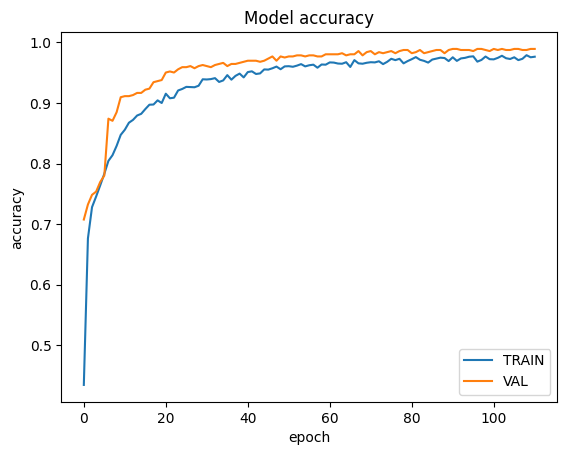

In [19]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()
     

In [20]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 5ms/step - loss: 0.3663 - accuracy: 0.9398


30/30 [==============================] - 1s 9ms/step
Confusion matrix, without normalization

Classification Report:
                                  precision    recall  f1-score   support

  1-falling-forward-using-hands       0.95      0.50      0.66        38
                     10-jumping       0.97      0.98      0.98       106
                      11-laying       1.00      0.99      1.00       153
  2-falling-forward-using-knees       0.25      0.12      0.17         8
            3-falling-backwards       1.00      0.50      0.67        14
             4-falling-sideways       1.00      0.36      0.53        11
5-falling-siting-in-empty-chair       0.88      0.83      0.86        18
                      6-walking       0.69      1.00      0.82       107
                     7-standing       1.00      1.00      1.00       224
                       8-siting       1.00      1.00      1.00       215
         9-picking-up-an-object       1.00      0.72      0.84        36

    

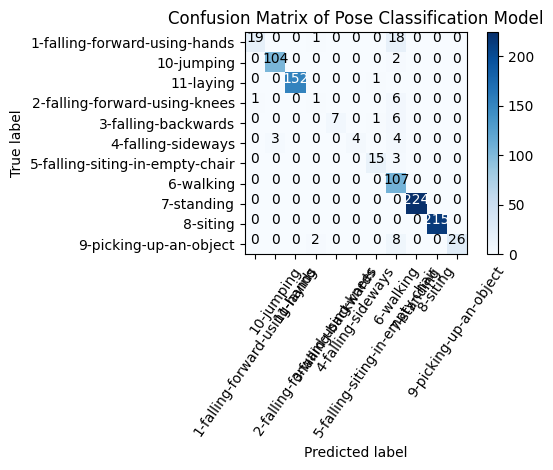

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Darzh\AppData\Local\Temp\tmpq6qw_6k9\assets


INFO:tensorflow:Assets written to: C:\Users\Darzh\AppData\Local\Temp\tmpq6qw_6k9\assets


Model size: 28KB


In [23]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [24]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.8311827956989247


In [28]:
!powershell Compress-Archive pose_labels.txt,pose_classifier.tflite pose_classifier.zip